***Спирина Татьяна Алексеевна DS-22***

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns

from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

**Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).**


In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [ ]:
data_russia = data[(data['location'] == 'Russia') & (data['date'] > '2020-03-02') ][{'date', 'total_cases', 'new_cases'}].reset_index(drop = True)
data_russia.loc[data_russia['new_cases'] == 0,'new_cases'] = 1
data_train = data_russia[:50]
data_test = data_russia[50:]

In [ ]:
data_train.tail()

,total_cases,date,new_cases
45,32008.0,2020-04-17,4070.0
46,36793.0,2020-04-18,4785.0
47,42853.0,2020-04-19,6060.0
48,47121.0,2020-04-20,4268.0
49,52763.0,2020-04-21,5642.0


**Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.**

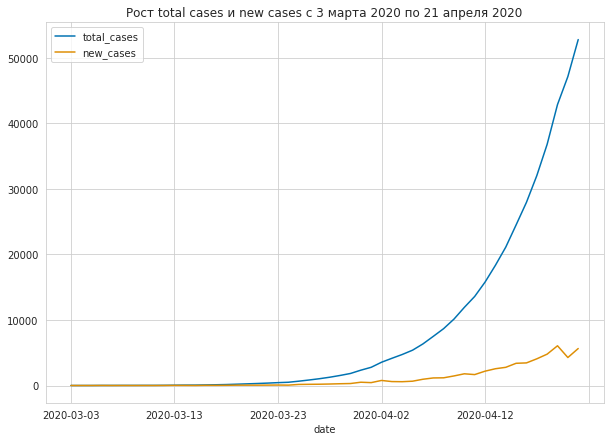

In [ ]:
data_train.plot(x='date', y = ['total_cases', 'new_cases'], figsize = (10,7), title = "Рост total cases и new cases с 3 марта 2020 по 21 апреля 2020" )

**a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.**

Для преобразования модели с экспоненциальным ростом в линейную функцию необходимо использовать логарифмирование левой и правой части

$$y(t) = a_{0} * b^{t}$$

$$ln(y) = ln(a_{0}) + t * ln(b)$$

$$t -> x$$
$$ln(y) = w_{0} + w_{1}*x $$

In [ ]:
y = [np.log(i) for i in data_train['total_cases']]
x = np.array([i for i in range(1,51)]).reshape(-1, 1)

In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x, y)
print("w1:", regr.coef_, "w0:", regr.intercept_)

w1: [0.19829091] w0: 1.62244623644881


**b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).**


Первый шаг эмипирического Байеса - поиск гипотезы максимального правдоподобия в классической статистике, то есть поиск параметров модели. В байесовском подходе и машинном обучении ищут апостериорное распределение

p(θ|D) ∝ p(D|θ)p(θ)

Мы должны выбрать априорное распределение на всех возможных значениях параметров и затем искать максимальную апостериорную гипотезу

Дли линейной регрессии - семейство Гауссиан


In [ ]:
sigma_noise = np.std(regr.predict(x) - y)
print("Дисперсия шума:", sigma_noise)

Дисперсия шума: 0.3490422059635659


$$p(w|t) = N(w|\mu_{N}, \Sigma_{N})$$
$$\mu_{N} = \Sigma_{N}(\Sigma_{0}^{-1}\mu_{0} + \frac{1}{\sigma^{2}}\Phi^{T}t)$$
$$\Sigma_{N} = (\Sigma_{0}^{-1} + \frac{1}{\sigma^{2}}\Phi^{T}\Phi)$$
$$t -> y ; \Phi -> X$$


In [ ]:
mu, sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

In [ ]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    
    x_matrix = np.concatenate((np.ones((len(x), 1)), x), axis=1)
    
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y ) )
    return mu_n, sigma_n

In [ ]:
cur_mu, cur_sigma = bayesian_update(mu, sigma, x, y, sigma_noise)
print("mu:", cur_mu)
print("sigma:", cur_sigma)

mu: [1.61436785 0.19853058]
sigma: [[ 9.99455630e-03 -2.96867588e-04]
 [-2.96867588e-04  1.16560495e-05]]


**c) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).**

In [ ]:
def myplot_sample_lines(mu, sigma, xs, n=20, points=None):
    
    my_w = np.random.multivariate_normal(mu, sigma, n)
    
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
    plt.ylim((-2, 50000))
    plt.xlim((xs[0], xs[-1]))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

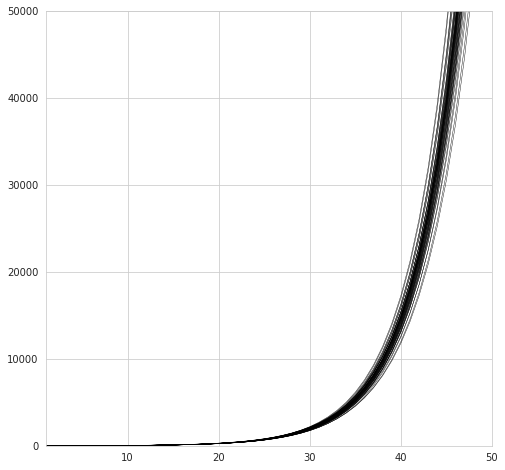

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
xs = np.linspace(1, 50, 50)
myplot_sample_lines(cur_mu, cur_sigma, xs, 50)

In [ ]:
from datetime import datetime   
START_DAY = datetime(2020, 3, 3)

MAY1 = (datetime(2020, 5, 1) - START_DAY).days + 1
JUNE1 = (datetime(2020, 6, 1) - START_DAY).days + 1
SEPT1 = (datetime(2020, 9, 1) - START_DAY).days + 1

In [ ]:
def sample_statistics(mu, sigma, xs, n=20):

    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
        
    return res

In [ ]:
def date_predictions(date, mu):
    return round(np.exp(mu[1]*np.array([date]) + mu[0])[0],2)

Предсказания случаев коронавируса:
1 мая 2020 - 748 781.73
1 июня 2020 - 352 531 615.55
1 сентября 2020 - 3.0165173531729516e+16


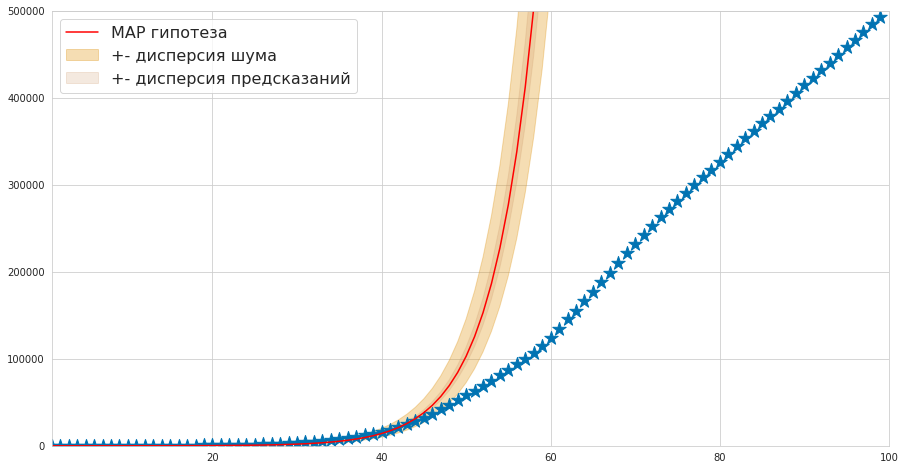

In [ ]:
def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 500000))
    
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - sigma_noise), np.exp(mu[1]*xs + mu[0] + sigma_noise), 
        color=palette[1], alpha=.3, label="+- дисперсия шума" )
    ax.fill_between(xs, np.exp( np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), 
        color=palette[5], alpha=.2, label="+- дисперсия предсказаний")

    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

xs = np.linspace(1, 100, 100)
x_n = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x_n, [[i for i in range(100)], data_russia[:100].total_cases])

preds = {"1 мая 2020":[], "1 июня 2020":[], "1 сентября 2020":[]}
preds["1 мая 2020"].append(date_predictions(MAY1, cur_mu))
preds["1 июня 2020"].append(date_predictions(JUNE1, cur_mu))
preds["1 сентября 2020"].append(date_predictions(SEPT1, cur_mu))
print("Предсказания случаев коронавируса:")
for k, v in preds.items():
  print(k, "-", '{0:,}'.format(round(np.mean(v),2)).replace(',', ' '))

Сравним с sklearn

In [ ]:

preds_sklearn = np.exp(regr.predict(np.array([MAY1, JUNE1, SEPT1]).reshape(-1, 1)))
print("Предсказания случаев коронавируса:")
print("1 мая 2020:", '{0:,}'.format(round(preds_sklearn[0], 2)).replace(',', ' '))
print("1 июня 2020:", '{0:,}'.format(round(preds_sklearn[1], 2)).replace(',', ' '))
print("1 сентября 2020:", '{0:,}'.format(round(preds_sklearn[2], 2)).replace(',', ' '))

Предсказания случаев коронавируса:
1 мая 2020: 744 077.87
1 июня 2020: 347 723 874.61
1 сентября 2020: 2.9104907396230516e+16


Sklearn и байесовский вывод дали примерно похожие результаты. Которые, однако, далеки от истинных.

**3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:**


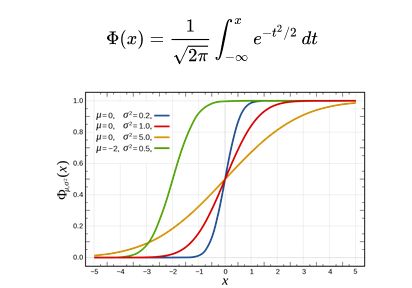

 **Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.**


**а)Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.**


$$\Phi(x) -> y $$
$$ y = C\int_\infty^xe^{-t^2/2}$$, где t^2 - произвольная квадратичная функция 
$$ y\prime = e^{w_{2}t^{2} + w_{1}t + w_{0}}$$
где y` - new cases  -> y
$$ln(y) = w_{2}t^{2} + w_{1}t + w_{0}$$


In [ ]:
y = [np.log(i) for i in data_train['new_cases']]
x = np.array([i for i in range(1,51)]).reshape(-1, 1)
x = np.hstack((x, x**2))

**b) Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.**

In [ ]:
regr2 = LinearRegression()
regr2.fit(x, y)
print("w1, w2:", regr2.coef_, "w0:", regr2.intercept_)

w1, w2: [ 0.27928241 -0.00182979] w0: -0.674043025361077


In [ ]:
sigma_noise = np.std(regr2.predict(x) - y)
print("Дисперсия шума:", sigma_noise)

Дисперсия шума: 0.4891695424595195


**c) Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?**

In [ ]:
mu, sigma = np.array([0, 0, 0]), 2*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [ ]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    
    x_matrix = np.concatenate((np.ones((len(x), 1)), x), axis=1)
    
    # print(mu.shape, sigma.shape, x_matrix.shape)
    
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), y ) )
    return mu_n, sigma_n

In [ ]:
cur_mu, cur_sigma = bayesian_update(mu, sigma, x, y, sigma_noise)
print("mu:", cur_mu)
print("sigma:", cur_sigma)

mu: [-0.65815757  0.27801196 -0.00180872]
sigma: [[ 4.56372295e-02 -3.61407824e-03  5.96369231e-05]
 [-3.61407824e-03  3.75436395e-04 -6.93174354e-06]
 [ 5.96369231e-05 -6.93174354e-06  1.36260727e-07]]


In [ ]:
def myplot_sample_lines(mu, sigma, xs, n=20, points=None):
    
    my_w = np.random.multivariate_normal(mu, sigma, n)
    # print(my_w)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs + w[2]*xs*xs), 'k-', lw=.4)
    plt.ylim((-2, 50000))
    plt.xlim((xs[0], 150))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)

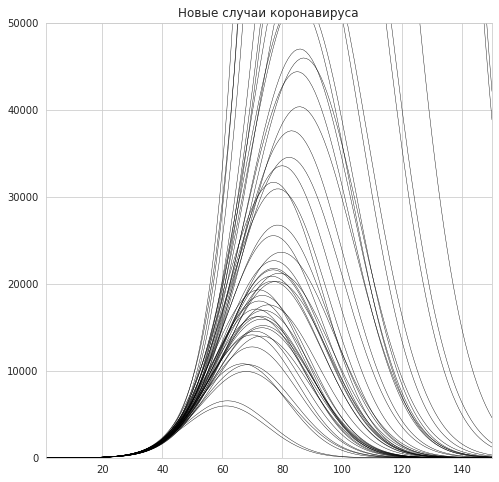

In [ ]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
xs = np.linspace(1, 150, 150)
plt.title("Новые случаи коронавируса")
myplot_sample_lines(cur_mu, cur_sigma, xs, 50)


In [ ]:
def sample_statistics(mu, sigma, xs, n=20):

    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    res_cum = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs*xs
        res_cum[i,:] = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs*xs))
    return res, res_cum

In [ ]:
def date_predictions(date, mu):
    new = round(np.exp(mu[2]*np.array([date])*np.array([date]) + mu[1]*np.array([date]) + mu[0])[0],2)
    total = round(np.cumsum(np.exp(mu[2]*np.array([range(1, date)])*np.array([range(1, date)]) + mu[1]*np.array([range(1, date)]) + mu[0]))[-1],2)
   
    return new, total

In [ ]:
def plot_predictions_total(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2000000))
    
    ax.plot(xs, np.cumsum(np.exp(mu[2]*xs*xs + mu[1]*xs + mu[0])), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.cumsum(np.exp(mu[2]*xs*xs +mu[1]*xs + mu[0] - sigma_noise)), np.cumsum(np.exp(mu[2]*xs*xs +mu[1]*xs + mu[0] + sigma_noise)), 
        color=palette[1], alpha=.3, label="+- дисперсия шума" )
    ax.fill_between(xs, np.cumsum(np.exp( np.mean(x, axis=0) - np.std(x, axis=0))), np.cumsum(np.exp(np.mean(x, axis=0) + np.std(x, axis=0))), 
        color=palette[5], alpha=.2, label="+- дисперсия предсказаний")

    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)
    plt.title("Суммарные случаи коронавируса")
def plot_predictions_new(xs, mu, x, points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 50000))
    
    ax.plot(xs, np.exp(mu[2]*xs*xs + mu[1]*xs + mu[0] ), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[2]*xs*xs +mu[1]*xs + mu[0] - sigma_noise), np.exp(mu[2]*xs*xs +mu[1]*xs + mu[0] + sigma_noise), 
        color=palette[1], alpha=.3, label="+- дисперсия шума" )
    ax.fill_between(xs, np.exp( np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), 
        color=palette[5], alpha=.2, label="+- дисперсия предсказаний")

    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)
    plt.title("Новые случаи коронавируса")
    


Предсказания новых случаев коронавируса:
1 мая 2020 - 13 509.59
1 июня 2020 - 15 723.17
1 сентября 2020 - 0.0


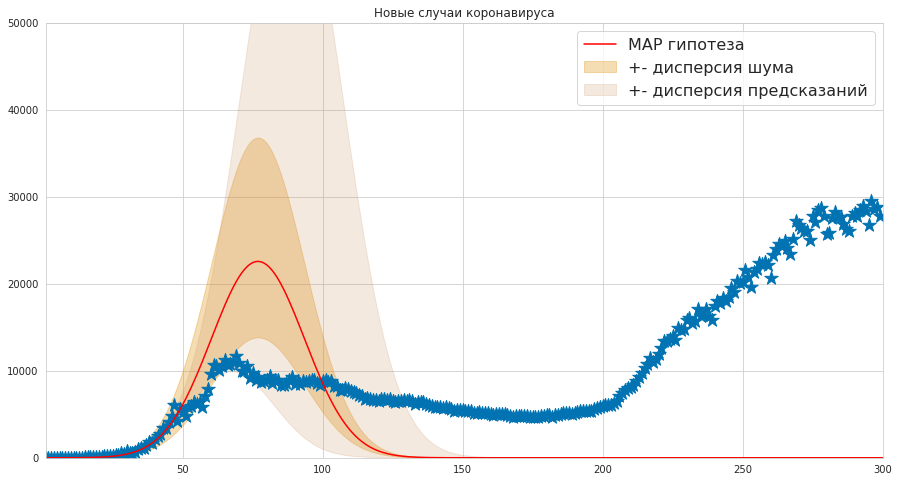

In [ ]:
xs = np.linspace(1, 300, 300)

x_n, x_n_cum = sample_statistics(cur_mu, cur_sigma, xs, n=1000)

plot_predictions_new(xs, cur_mu, x_n, [[i for i in range(300)], data_russia[:300].new_cases])

preds_new = {"1 мая 2020":[], "1 июня 2020":[], "1 сентября 2020":[]}
preds_new["1 мая 2020"].append(date_predictions(MAY1, cur_mu)[0])
preds_new["1 июня 2020"].append(date_predictions(JUNE1, cur_mu)[0])
preds_new["1 сентября 2020"].append(date_predictions(SEPT1, cur_mu)[0])
print("Предсказания новых случаев коронавируса:")
for k, v in preds_new.items():
  print(k, "-", '{0:,}'.format(round(np.mean(v),2)).replace(',', ' '))


Предсказания суммарных случаев коронавируса по MAP:
1 мая 2020 - 139 540.17
1 июня 2020 - 747 381.92
1 сентября 2020 - 941 104.7


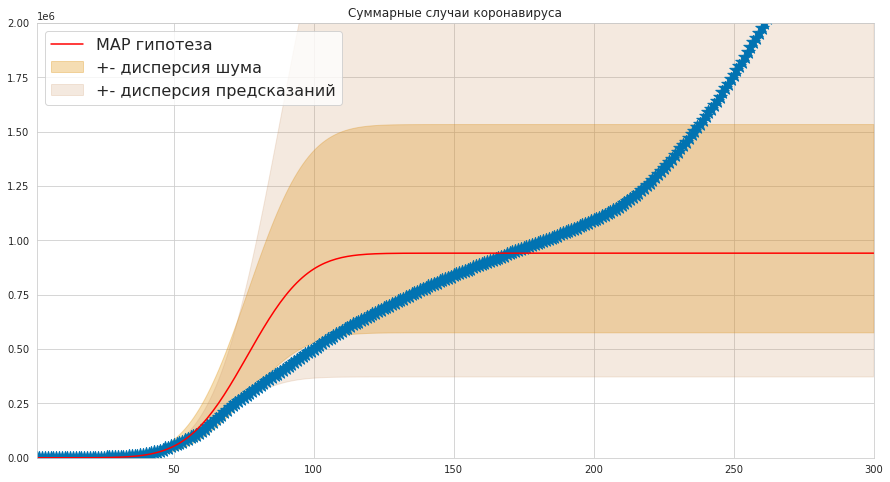

In [ ]:
plot_predictions_total(xs, cur_mu, x_n, [[i for i in range(300)], data_russia[:300].total_cases])

preds_new = {"1 мая 2020":[], "1 июня 2020":[], "1 сентября 2020":[]}
preds_new["1 мая 2020"].append(date_predictions(MAY1, cur_mu)[1])
preds_new["1 июня 2020"].append(date_predictions(JUNE1, cur_mu)[1])
preds_new["1 сентября 2020"].append(date_predictions(SEPT1, cur_mu)[1])
print("Предсказания суммарных случаев коронавируса по MAP:")
for k, v in preds_new.items():
  print(k, "-", '{0:,}'.format(round(np.mean(v),2)).replace(',', ' '))


In [ ]:
q10 = np.quantile(x_n_cum, 0.1, axis = 0)[299]
q90 = np.quantile(x_n_cum, 0.9, axis = 0)[299]
print("Оптимистичный сценарий (10-й процентиль): ", '{0:,}'.format(round(q10,2)).replace(',', ' '))
print("Пессимистичный сценарий (90-й процентиль): ", '{0:,}'.format(round(q90,2)).replace(',', ' '))
print("Реальное число случаев на 300 день: ", '{0:,}'.format(data_russia.loc[299]['total_cases']).replace(',', ' '))
print("Реальное число случаев на конец представленных наблюдений: ", '{0:,}'.format(data_russia.loc[733]['total_cases']).replace(',', ' '))

Оптимистичный сценарий (10-й процентиль):  317 205.69
Пессимистичный сценарий (90-й процентиль):  5 020 174.34
Реальное число случаев на 300 день:  3 019 972.0
Реальное число случаев на конец представленных наблюдений:  16 698 139.0



**Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?**

**Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?**

Меня смущает нормальна ли такая дисперсия предсказаний. Я пробовала увеличить тренировочную выборку. Это привело к уменьшению дисперсии предсказаний, но итоговый прогноз, в таком случае, совпадал с реальной картиной еще хуже. Поэтому я не стала делать моделирование для других стран, тк не уверена в успехе текущей модели. 
Если смотреть на получившийся результат, то картина коронавируса, можно сказать, радужная. Хотя мы знаем, что это не так. 
В любом случае, мне кажется, что только этой модели не должно хватать для вынесения решения о локдауне. Мне представляется, что данные решения должны выноситься на моделировании эпидемий (SIR/SIRS модели какие-то), а так же учитывать нагрузку на медицинскую систему, для чего нужны статистики госпитализаций, и сопоставление пиковых моментов с емкостью больниц итд.
